# Checkpoint 3:
## Modelo Random Forest

In [49]:
!pip install 'dtreeviz'

In [50]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-20 00:09:14--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv.2’

hotels_train.csv.2  100%[===================>]   9.33M  --.-KB/s    in 0.03s   

2023-10-20 00:09:14 (302 MB/s) - ‘hotels_train.csv.2’ saved [9788953/9788953]



In [51]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-20 00:09:15--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv.2’

hotels_test.csv.2   100%[===================>]   4.23M  --.-KB/s    in 0.02s   

2023-10-20 00:09:15 (254 MB/s) - ‘hotels_test.csv.2’ saved [4432981/4432981]



In [52]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [53]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

# Modificando el dataset

In [54]:
df_filtrado = df_filtrado.drop('id', axis=1)

In [55]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
df_filtrado.agent = df_filtrado.agent.replace(np.nan, -1)
df_filtrado.company = df_filtrado.company.replace(np.nan, -1)

In [56]:
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [57]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)
df_filtrado = df_filtrado.replace({'children': 10}, value=0)
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'market_segment':  'Undefined'}, value='Online TA')
df_filtrado = df_filtrado.replace({'distribution_channel':  'Undefined'}, value='TA/TO')

# Encoding and separation columns

Usando una proporción de 70 y 30 separo mi dataset en train y validation

In [58]:
df_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,0,No Deposit,9.0,-1.0,0,Transient,115.5,0,1,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,0,No Deposit,-1.0,-1.0,0,Transient,42.0,1,0,0


In [59]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=0)

# Busqueda de hiperparametros

In [61]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini', 'entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(2,20)),
               #'ccp_alpha':np.linspace(0,0.001,10),
               'max_depth':list(range(1,50)),
               'n_estimators':list(range(50,100))}


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = RandomForestClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [62]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 47, 'criterion': 'entropy'}
0.872333536725554


In [63]:
random_forest_model = RandomForestClassifier(criterion=randomcv.best_params_['criterion'],
                                         max_depth = randomcv.best_params_['max_depth'],
                                         #ccp_alpha=randomcv.best_params_['ccp_alpha'],
                                         min_samples_leaf=randomcv.best_params_['min_samples_leaf'],
                                         min_samples_split=randomcv.best_params_['min_samples_split'],
                                         n_estimators=randomcv.best_params_['n_estimators'],
                                         random_state=2)
#Entrenamos el modelo
model = random_forest_model.fit(X = x_train.sort_index(axis=1), y = y_train)

In [64]:
y_pred = model.predict(x_test.sort_index(axis=1))
#Valores Predichos
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [65]:
y_test.values

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,0,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

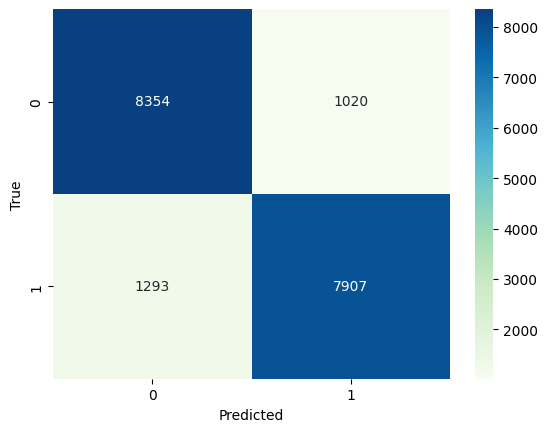

In [67]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [68]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.875471088618499
Recall: 0.8594565217391305
Precision: 0.8857398902206789
f1 score: 0.8724002868648978


In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      9374
           1       0.89      0.86      0.87      9200

    accuracy                           0.88     18574
   macro avg       0.88      0.88      0.88     18574
weighted avg       0.88      0.88      0.88     18574



# Test prediction

## Modificando el Dataset

In [70]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [71]:
df_test_filtrado['reservation_status_date']

0        2016-04-04
1        2016-01-22
2        2016-08-24
3        2016-11-05
4        2016-10-18
            ...    
26530    2017-04-26
26531    2016-09-06
26532    2016-08-04
26533    2017-03-07
26534    2016-03-27
Name: reservation_status_date, Length: 26535, dtype: object

In [72]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [73]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, -1)
df_test_filtrado.company = df_test_filtrado.company.replace(np.nan, -1)
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

In [74]:
df_test_filtrado.isna().any()

hotel                             False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
company                           False
days_in_waiting_list              False


Tratamos de eliminar los paises que solo aparecen en el set de test y no en el de train.

In [75]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['ASM', 'NIC', 'MLI', 'ATF', 'BFA', 'UZB', 'KHM', 'SLV', 'DJI', 'TMP', 'DMA', 'SMR']


In [76]:
df_test_filtrado["country"].value_counts()

PRT    12142
GBR     2387
FRA     2118
ESP     1757
DEU     1405
       ...  
PAK        1
RWA        1
MLT        1
CMR        1
GAB        1
Name: country, Length: 123, dtype: int64

In [77]:
#Modificando algunos outliers
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)

In [78]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)


## Prediccion

In [79]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
assigned_room_type_L


In [80]:
lista = ds_encodeado.columns
columnas_a_eliminar = []
for colum in df_test_encodeado.columns:
  if(colum not in lista):
    print(colum)
    columnas_a_eliminar.append(colum)

# df_test_encodeado = df_test_encodeado.drop(columns=columnas_a_eliminar)

In [81]:
test_pred_2 = model.predict(df_test_encodeado.sort_index(axis=1))
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [82]:
# Crear un DataFrame con las columnas "id" e "is_canceled"
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [83]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [84]:
df_final_finalisimo.head(10)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
6,8c4171ad-9837-4468-ac8e-8cb3d5a41b55,0
7,3ce60033-4529-4314-be77-db4a7737f326,0
8,7ab807a4-5e90-4205-b66e-0188696cc34b,0
9,a0ab0509-c8b0-4a2c-9f27-21f26e186520,0


In [85]:
df_final_finalisimo.to_csv('submission.csv', index=False)
